In [1]:
# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# Load the dataset from the CSV file
df = pd.read_csv("/content/drive/MyDrive/new_retail_data.csv")
print(f"Successfully loaded dataset. Initial shape: {df.shape}")

Successfully loaded dataset. Initial shape: (302010, 30)


In [3]:
# DATA CLEANING & PREPROCESSING
# This section prepares the data for analysis by filtering, cleaning, and handling inconsistencies.

# Filter data for the specific scope: Canadian Grocery sector
df = df[(df['Country'].str.strip().str.lower() == 'canada') &
        (df['Product_Category'].str.strip().str.lower() == 'grocery')].copy()
print(f"Filtered for Canadian grocery sector. New shape: {df.shape}")

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Drop columns that are not relevant for this analysis
columns_to_drop = ['Transaction_ID', 'Name', 'Email', 'Phone', 'Address', 'Country', 'Product_Category']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert Date and Time to a single Datetime object for time-series analysis
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Convert numeric columns to the correct data type, coercing errors
numeric_columns = ['Amount', 'Total_Amount', 'Total_Purchases', 'Ratings', 'Age']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
# First, drop rows where key information (like Datetime or Total_Amount) is missing
df.dropna(subset=['Datetime', 'Total_Amount'], inplace=True)
print(f"Shape after dropping essential missing values: {df.shape}")

# Fill categorical NaNs with mode
categorical_columns = ['Income', 'Customer_Segment', 'Feedback', 'Shipping_Method',
                       'Payment_Method', 'Order_Status', 'Product_Brand', 'Product_Type']
for col in categorical_columns:
    if col in df.columns and df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Outlier Detection and Handling (As required by the assignment)
# We use the Interquartile Range (IQR) method to identify and remove extreme outliers
# in the 'Total_Amount' column, which could skew the analysis.
Q1 = df['Total_Amount'].quantile(0.25)
Q3 = df['Total_Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['Total_Amount'] >= lower_bound) & (df['Total_Amount'] <= upper_bound)]
print(f"Shape after removing outliers from 'Total_Amount': {df.shape}")
print("--- Section 2: Data Cleaning & Preprocessing Complete ---")

Filtered for Canadian grocery sector. New shape: (8892, 30)
Shape after dropping essential missing values: (8859, 24)
Shape after removing outliers from 'Total_Amount': (8745, 24)
--- Section 2: Data Cleaning & Preprocessing Complete ---


<ipython-input-3-604132639>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)



--- Social Factor Analysis ---


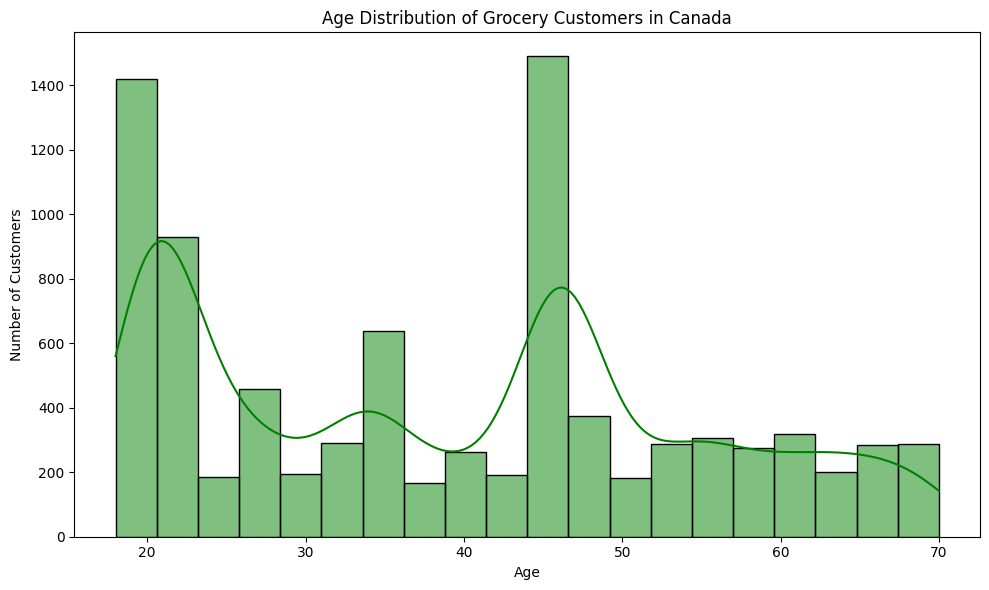

<ipython-input-6-1377996052>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='Set2')


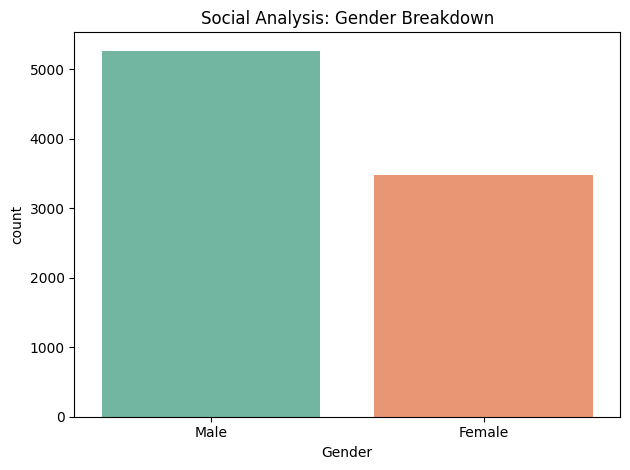

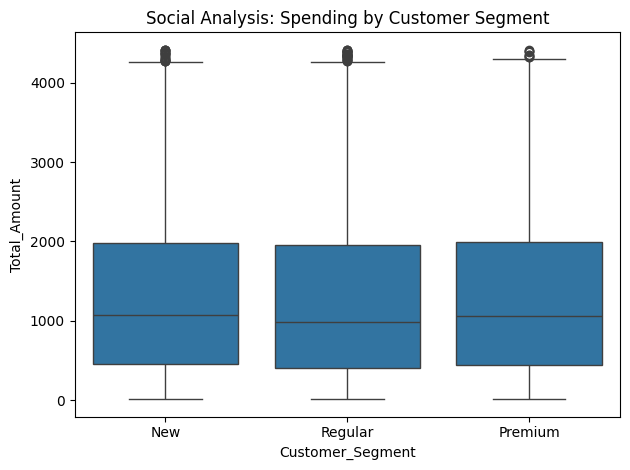

T-test (Gender vs. Spending): Statistic=-0.864, p-value=0.3876
Result: No statistically significant difference in spending between genders.

ANOVA (Product Type vs. Spending): Statistic=2.958, p-value=0.0520
Result: No statistically significant difference in spending across top product types.

--- Economic Factor Analysis ---


<ipython-input-6-1377996052>:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_time['Total_Amount'].resample('M').sum()


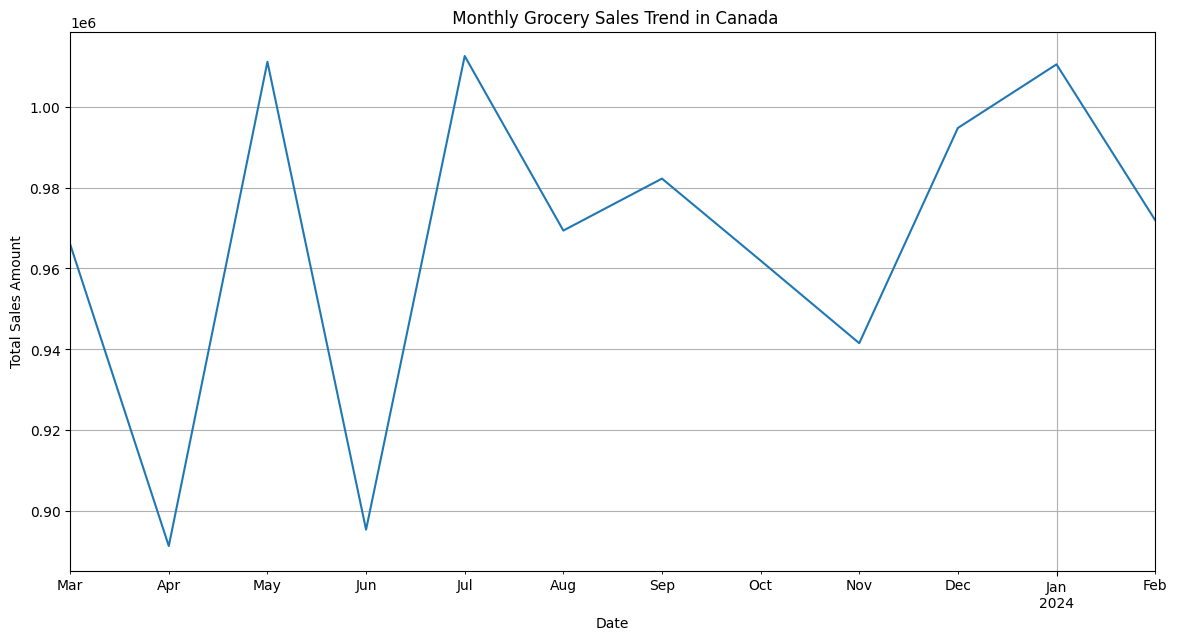

Generated plot for Monthly sales trends.


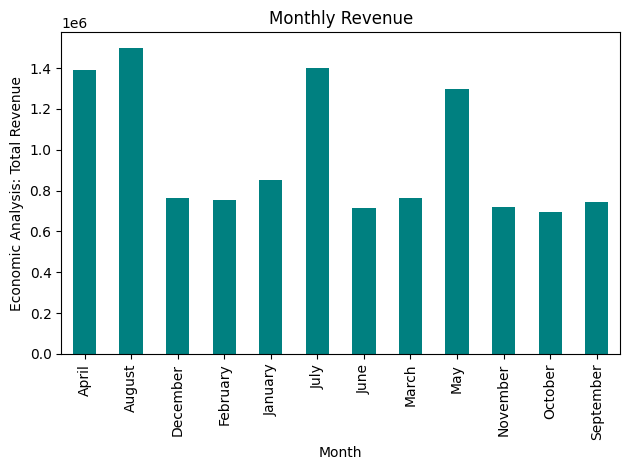

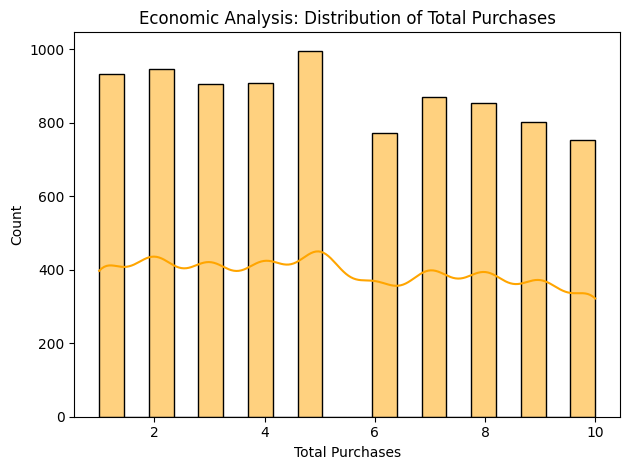

<ipython-input-6-1377996052>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income', y='Total_Amount', data=df, palette='coolwarm')


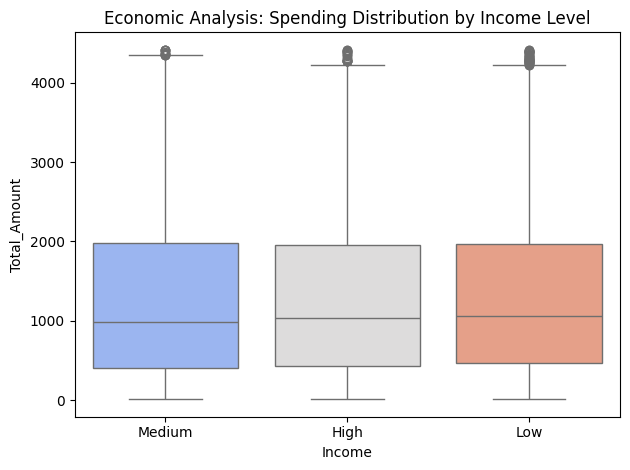


Pearson Correlation (Age vs. Total Purchases): r=nan, p-value=nan
Result: No significant correlation between customer age and total purchases.

--- Technological Factor Analysis (Proxy) ---


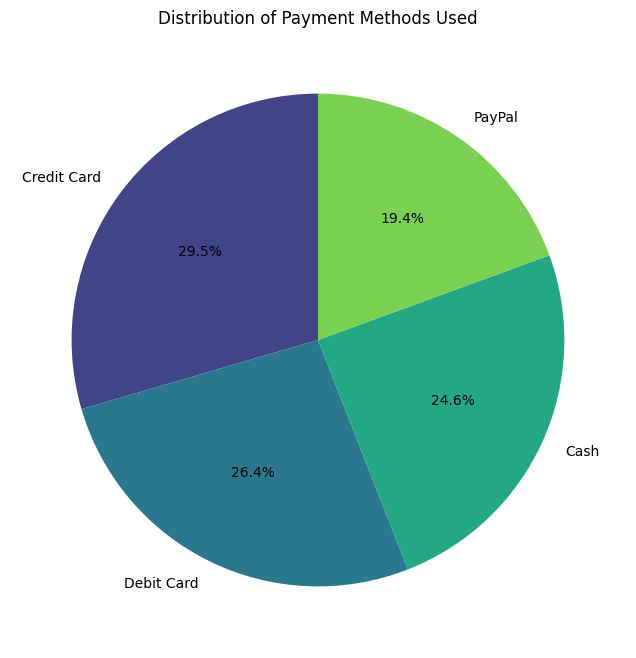

Generated pie chart for payment method distribution.


<ipython-input-6-1377996052>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Feedback', data=df, order=df['Feedback'].value_counts().index, palette='viridis')


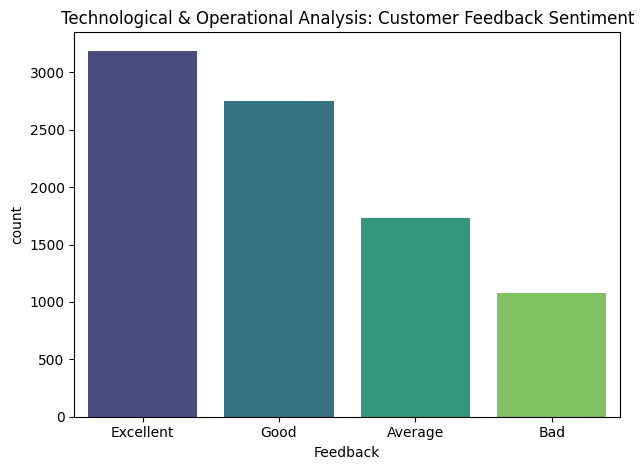

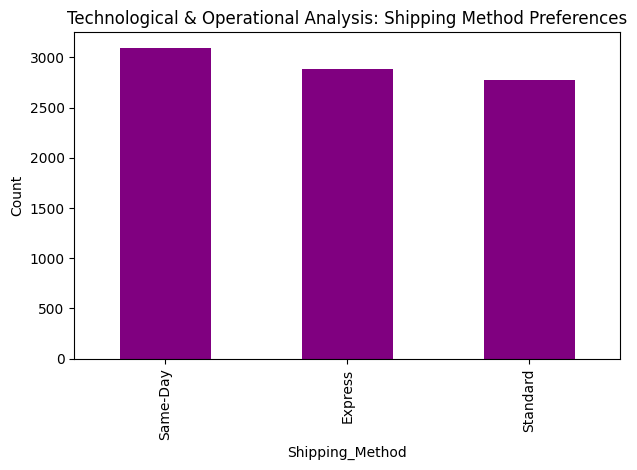

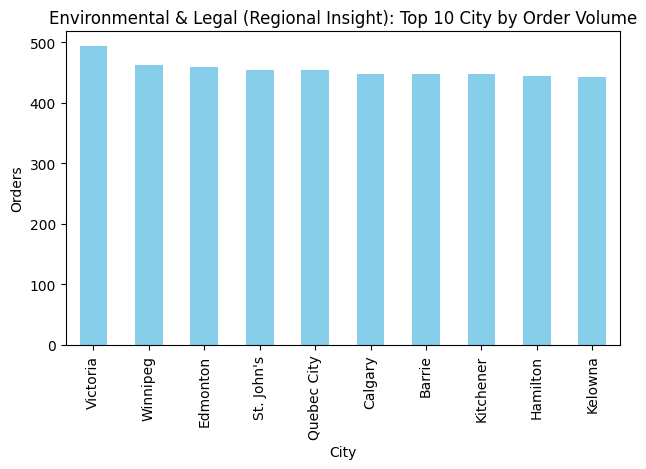

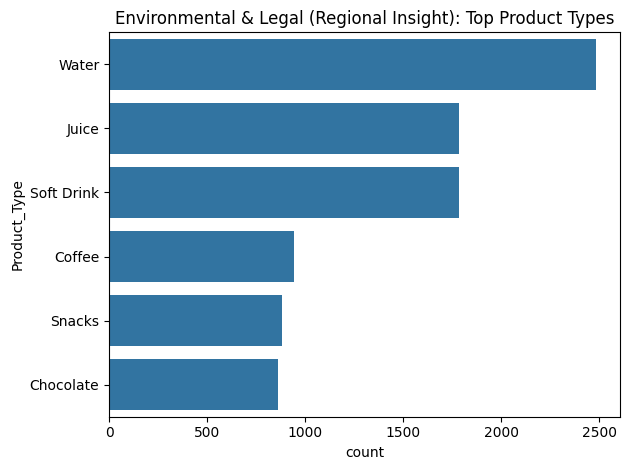

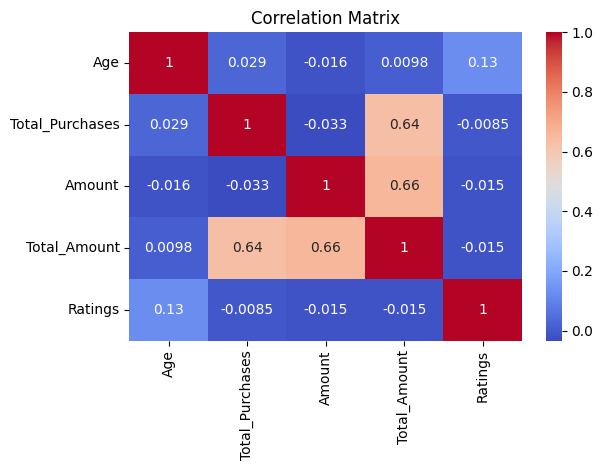

In [6]:
# PESTEL FRAMEWORK ANALYSIS
# This section performs statistical analysis and creates visualizations organized by the PESTEL framework factors.

# --- SOCIAL FACTOR ANALYSIS ---
# Analyzing consumer demographics and behavior.

print("\n--- Social Factor Analysis ---")
# Age Distribution of Customers
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='green')
plt.title('Age Distribution of Grocery Customers in Canada')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# Gender Distribution
sns.countplot(x='Gender', data=df, palette='Set2')
plt.title('Social Analysis: Gender Breakdown')
plt.tight_layout()
plt.show()

# Customer Segment Spending
sns.boxplot(x='Customer_Segment', y='Total_Amount', data=df)
plt.title('Social Analysis: Spending by Customer Segment')
plt.tight_layout()
plt.show()

# Spending Habits by Gender (T-test)
male_spending = df[df['Gender'].str.lower() == 'male']['Total_Amount']
female_spending = df[df['Gender'].str.lower() == 'female']['Total_Amount']
t_stat, p_gender = ttest_ind(male_spending, female_spending)
print(f"T-test (Gender vs. Spending): Statistic={t_stat:.3f}, p-value={p_gender:.4f}")
if p_gender < 0.05:
    print("Result: There is a statistically significant difference in spending between genders.")
else:
    print("Result: No statistically significant difference in spending between genders.")

# Product Preference Analysis (ANOVA)
# Analyze if spending differs across the top 3 product types
top_product_types = df['Product_Type'].value_counts().index[:3]
grouped_by_product = [df[df['Product_Type'] == pt]['Total_Amount'] for pt in top_product_types]
f_stat, p_product = f_oneway(*grouped_by_product)
print(f"\nANOVA (Product Type vs. Spending): Statistic={f_stat:.3f}, p-value={p_product:.4f}")
if p_product < 0.05:
    print("Result: There is a statistically significant difference in spending across top product types.")
else:
    print("Result: No statistically significant difference in spending across top product types.")


# --- ECONOMIC FACTOR ANALYSIS ---
# Analyzing spending trends and correlations.

print("\n--- Economic Factor Analysis ---")
# Trend Analysis of Sales Over Time
# Set Datetime as the index for time-series plotting
df_time = df.set_index('Datetime')
# Resample data by week to see trends more clearly
monthly_sales = df_time['Total_Amount'].resample('M').sum()

plt.figure(figsize=(14, 7))
monthly_sales.plot()
plt.title(' Monthly Grocery Sales Trend in Canada')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.show()
print("Generated plot for Monthly sales trends.")

# Monthly Total Revenue
monthly_revenue = df.groupby('Month')['Total_Amount'].sum().sort_index()
monthly_revenue.plot(kind='bar', color='teal', title='Monthly Revenue')
plt.ylabel('Economic Analysis: Total Revenue')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# Total Purchases Distribution
sns.histplot(df['Total_Purchases'], bins=20, kde=True, color='orange')
plt.title('Economic Analysis: Distribution of Total Purchases')
plt.xlabel('Total Purchases')
plt.tight_layout()
plt.show()

# Revenue by Income Group
sns.boxplot(x='Income', y='Total_Amount', data=df, palette='coolwarm')
plt.title('Economic Analysis: Spending Distribution by Income Level')
plt.tight_layout()
plt.show()

# Correlation between Age and Total Purchases
corr_age_purchases, p_age = pearsonr(df['Age'], df['Total_Purchases'])
print(f"\nPearson Correlation (Age vs. Total Purchases): r={corr_age_purchases:.3f}, p-value={p_age:.4f}")
if p_age < 0.05:
    print("Result: There is a significant correlation between customer age and total purchases.")
else:
    print("Result: No significant correlation between customer age and total purchases.")


# --- TECHNOLOGICAL & OPERATIONAL FACTOR ANALYSIS (Proxy) ---
# Using payment method as a proxy for technology adoption by consumers.

print("\n--- Technological Factor Analysis (Proxy) ---")
payment_distribution = df['Payment_Method'].value_counts()

plt.figure(figsize=(10, 8))
payment_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90,
                          colors=sns.color_palette('viridis', len(payment_distribution)))
plt.title('Distribution of Payment Methods Used')
plt.ylabel('')  # Hide the y-label for pie charts
plt.show()
print("Generated pie chart for payment method distribution.")

# Feedback Ratings Distribution
sns.countplot(x='Feedback', data=df, order=df['Feedback'].value_counts().index, palette='viridis')
plt.title('Technological & Operational Analysis: Customer Feedback Sentiment')
plt.tight_layout()
plt.show()

# Shipping Method Usage
df['Shipping_Method'].value_counts().plot(kind='bar', color='purple')
plt.title('Technological & Operational Analysis: Shipping Method Preferences')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- Environmental & Legal (Regional Insight) ---
# Order Distribution by Province
top_states = df['City'].value_counts().nlargest(10)
top_states.plot(kind='bar', color='skyblue')
plt.title('Environmental & Legal (Regional Insight): Top 10 City by Order Volume')
plt.ylabel('Orders')
plt.tight_layout()
plt.show()

# Product Type Distribution (Useful for environmental analysis e.g., packaging, perishables)
sns.countplot(y='Product_Type', data=df, order=df['Product_Type'].value_counts().index[:10])
plt.title('Environmental & Legal (Regional Insight): Top Product Types')
plt.tight_layout()
plt.show()

# --- Correlation Analysis
correlation_matrix = df[['Age', 'Total_Purchases', 'Amount', 'Total_Amount', 'Ratings']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [7]:
# SUMMARY OF HYPOTHESIS TEST RESULTS
print("\n--- Section 4: Summary of All Statistical Test Results ---")

print("\n1. Gender vs. Total Amount (T-test)")
print(f"   - T-Statistic: {t_stat:.3f}")
print(f"   - P-value: {p_gender:.4f}")
print(f"   - Interpretation: {'Reject H0 - Significant difference found.' if p_gender < 0.05 else 'Fail to reject H0 - No significant difference.'}")

print("\n2. Product Type vs. Total Amount (ANOVA)")
print(f"   - F-Statistic: {f_stat:.3f}")
print(f"   - P-value: {p_product:.4f}")
print(f"   - Interpretation: {'Reject H0 - Significant difference found.' if p_product < 0.05 else 'Fail to reject H0 - No significant difference.'}")



print("\n--- End of Analysis Script ---")
print("Next step: Interpret these results and write the final report.")


--- Section 4: Summary of All Statistical Test Results ---

1. Gender vs. Total Amount (T-test)
   - T-Statistic: -0.864
   - P-value: 0.3876
   - Interpretation: Fail to reject H0 - No significant difference.

2. Product Type vs. Total Amount (ANOVA)
   - F-Statistic: 2.958
   - P-value: 0.0520
   - Interpretation: Fail to reject H0 - No significant difference.

3. Age vs. Total Purchases (Pearson Correlation)
   - Correlation Coefficient (r): nan
   - P-value: nan
   - Interpretation: Fail to reject H0 - No significant correlation.

4. Ratings vs. Total Amount (Pearson Correlation)
   - Correlation Coefficient (r): nan
   - P-value: nan
   - Interpretation: Fail to reject H0 - No significant correlation.

--- End of Analysis Script ---
Next step: Interpret these results and write the final report.



--- 3.4: Predictive Modeling - Sales Forecasting ---


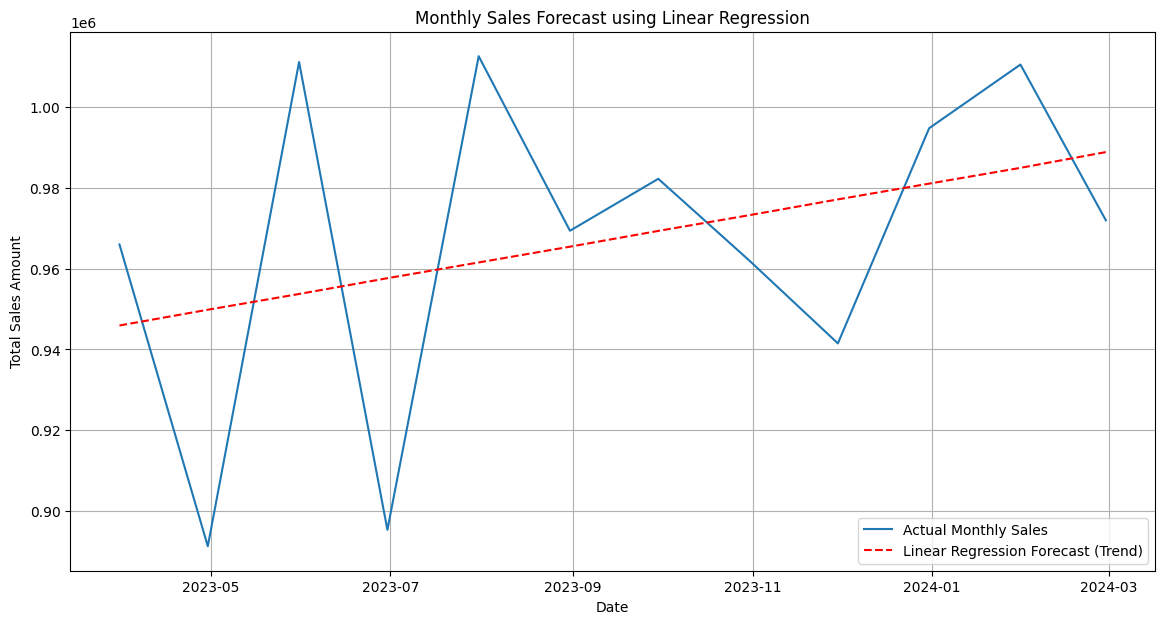

Sales Forecast Model Results:
  - Model Intercept: 945935.52
  - Model Slope (Trend): 3899.90
  - Interpretation: The model predicts an average increase in sales of $3899.90 per month.
R-squared: 0.11772209297714364
Mean Squared Error: 1358338951.4298308


In [8]:
# PREDICTIVE MODELING - SALES FORECASTING
print("\n--- 3.4: Predictive Modeling - Sales Forecasting ---")

# Prepare data for the model
# We use monthly sales data for forecasting
monthly_sales_df = monthly_sales.reset_index()
monthly_sales_df['Time'] = np.arange(len(monthly_sales_df)) # Create a numeric time index

# Define features (X) and target (y)
X = monthly_sales_df[['Time']] # Feature: Time index
y = monthly_sales_df['Total_Amount']   # Target: Sales amount

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Get the predictions from the model
y_pred = model.predict(X)

# Visualize the model's forecast
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_df['Datetime'], y, label='Actual Monthly Sales')
plt.plot(monthly_sales_df['Datetime'], y_pred, color='red', linestyle='--', label='Linear Regression Forecast (Trend)')
plt.title('Monthly Sales Forecast using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.legend()
plt.grid(True)
plt.show()

# Print the model coefficients to interpret the trend
slope = model.coef_[0]
intercept = model.intercept_
print("Sales Forecast Model Results:")
print(f"  - Model Intercept: {intercept:.2f}")
print(f"  - Model Slope (Trend): {slope:.2f}")
if slope > 0:
    print(f"  - Interpretation: The model predicts an average increase in sales of ${slope:.2f} per month.")
else:
    print(f"  - Interpretation: The model predicts an average decrease in sales of ${-slope:.2f} per month.")

# Calculate and print R-squared
r_squared = model.score(X, y)
print(f"R-squared: {r_squared}")

# You can also calculate and print Mean Squared Error (MSE)
y_pred = model.predict(X)
mse = np.mean((y - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



--- Advanced Predictive Modeling - Sales Forecasting with Prophet ---
Fitting Prophet model... This might take a moment.


INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tz37ae1/_1f3fp1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tz37ae1/k_brpn7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93118', 'data', 'file=/tmp/tmp7tz37ae1/_1f3fp1x.json', 'init=/tmp/tmp7tz37ae1/k_brpn7m.json', 'output', 'file=/tmp/tmp7tz37ae1/prophet_modelydtwvld5/prophet_model-20250615175340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:53:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Prophet model fitted.


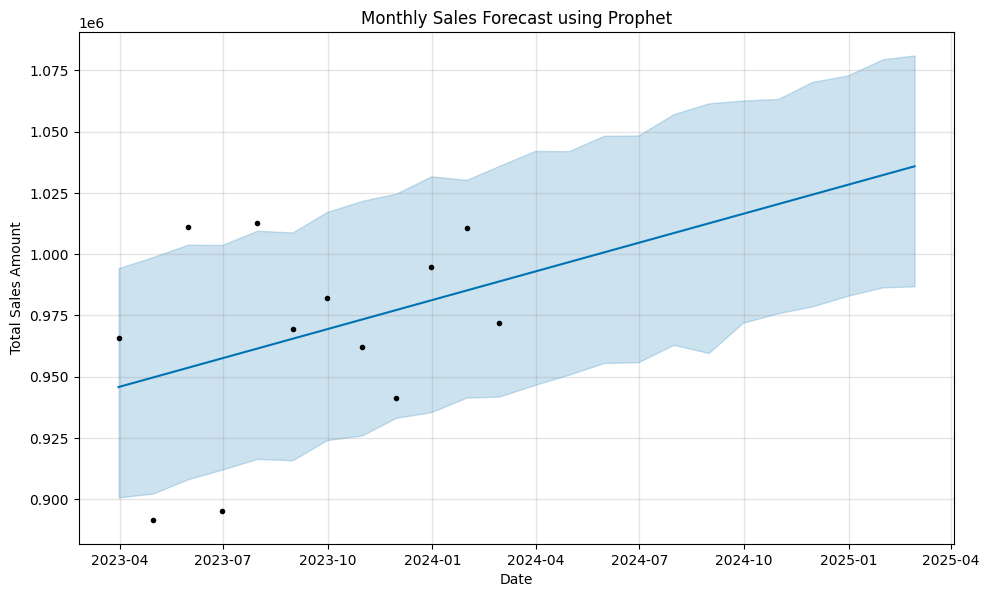

Generated plot for Prophet sales forecast.


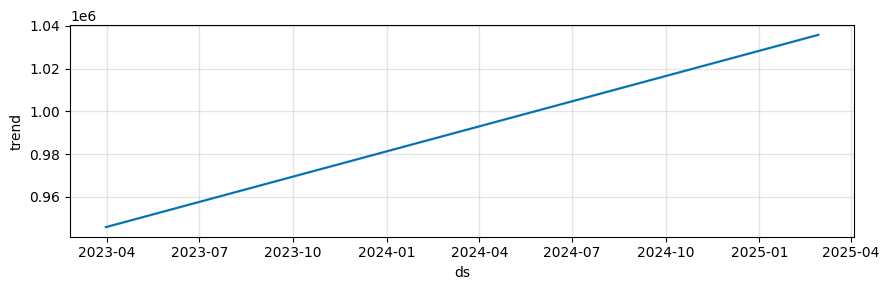

Generated plot for Prophet forecast components (trend, seasonality).

Prophet Model Evaluation on Historical Data:
  - Mean Absolute Error (MAE): 30738.21
  - Mean Squared Error (MSE): 1356261429.44
  - Root Mean Squared Error (RMSE): 36827.45
  - Linear Regression R-squared: 0.12
  - Linear Regression MSE: 1358338951.43

--- End of Advanced Predictive Modeling with Prophet ---


In [9]:
print("\n--- Advanced Predictive Modeling - Sales Forecasting with Prophet ---")

# Prepare data for Prophet: Prophet requires columns named 'ds' (datetime) and 'y' (value)
prophet_df = monthly_sales_df.rename(columns={'Datetime': 'ds', 'Total_Amount': 'y'})

# Initialize the Prophet model
# You can add parameters like seasonality_mode='multiplicative' or specify daily_seasonality, weekly_seasonality etc.
# based on your data's patterns. For now, we'll let Prophet detect it.
model_prophet = Prophet()

# Fit the model to your historical sales data
print("Fitting Prophet model... This might take a moment.")
model_prophet.fit(prophet_df)
print("Prophet model fitted.")

# Create a DataFrame with future dates for forecasting
# Let's forecast for the next 12 months (adjust as needed)
future = model_prophet.make_future_dataframe(periods=12, freq='M') # 'M' for month end frequency

# Make predictions
forecast = model_prophet.predict(future)

# Visualize the Prophet forecast
fig1 = model_prophet.plot(forecast)
plt.title('Monthly Sales Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.show()
print("Generated plot for Prophet sales forecast.")

# Visualize the components (trend, seasonality) of the forecast
fig2 = model_prophet.plot_components(forecast)
plt.show()
print("Generated plot for Prophet forecast components (trend, seasonality).")

# Evaluate Prophet Model performance on historical data (optional, but good for comparison)
# We'll compare the actual historical values with the Prophet's fitted values
# Ensure 'forecast' and 'prophet_df' are aligned by 'ds'
merged_df = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate R-squared for Prophet on historical data
# Note: For time series, R-squared can be misleading. MAE, MSE, RMSE are often more appropriate.
y_true_prophet = merged_df['y']
y_pred_prophet = merged_df['yhat']

# Calculate Mean Absolute Error (MAE)
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)

# Calculate Mean Squared Error (MSE)
mse_prophet = mean_squared_error(y_true_prophet, y_pred_prophet)

# Calculate Root Mean Squared Error (RMSE)
rmse_prophet = math.sqrt(mse_prophet)

print("\nProphet Model Evaluation on Historical Data:")
print(f"  - Mean Absolute Error (MAE): {mae_prophet:.2f}")
print(f"  - Mean Squared Error (MSE): {mse_prophet:.2f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse_prophet:.2f}")

# Compare with Linear Regression's R-squared and MSE for context
# (Assuming you printed them earlier for Linear Regression)
print(f"  - Linear Regression R-squared: {r_squared:.2f}")
print(f"  - Linear Regression MSE: {mse:.2f}")

print("\n--- End of Advanced Predictive Modeling with Prophet ---")